### Import Necessary Libraries

In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity
from einops import rearrange
from einops.layers.torch import Rearrange
from timm.models.layers import trunc_normal_, DropPath
from scipy.ndimage import gaussian_filter

/home/g202319350/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


### Model Config

In [2]:
config_ = 'full-sae'

### Get and Preprocess Dataset

In [3]:
def add_speckle_noise(image):
    """
    Adds realistic ultrasound-inspired speckle noise to a grayscale image.
    Noise level increases with sigma in [0, 1].

    Parameters:
    - image (np.ndarray): Input grayscale image (2D array).
    - sigma (float): Noise level in [0, 1]; 0 = low, 1 = high

    Returns:
    - noisy_image (np.ndarray): Output image with speckle noise (uint8).
    """
    sigma_list = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
    sigma = random.choice(sigma_list)

    sigma = np.clip(sigma, 0, 1)
    strength = 0.3 + sigma * 0.7     # Linearly scale noise strength from 0.3 to 1.0
    blur_sigma = 0.5 * (1 - sigma)   # Optional blur: less blur at high noise

    # Normalize input
    image = image.astype(np.float32) / 255.0
    height, width = image.shape

    # Generate Rayleigh-distributed noise
    real = np.random.randn(height, width)
    imag = np.random.randn(height, width)
    rayleigh = np.sqrt(real**2 + imag**2)

    # Blur the speckle less as sigma increases
    if blur_sigma > 0 and random.random() <= 0.6:
        speckle = gaussian_filter(rayleigh, sigma=blur_sigma)
    else:
        speckle = rayleigh

    # Normalize and amplify
    speckle /= np.mean(speckle)
    speckle = 1 + strength * (speckle - 1)

    # Apply to image
    noisy = np.clip(image * speckle, 0, 1)

    return (noisy * 255).astype(np.uint8)

# List all image paths
image_dir = "../datasets/coco/original"
all_images = sorted([
    os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
    if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
])

# Split into 95% train, 5% val
train_paths, val_paths = train_test_split(all_images, test_size=0.05, random_state=42)

class ImagePatchDataset(Dataset):
    def __init__(self, image_paths, patch_size=128):
        self.patch_size = patch_size
        self.patches = []

        for img_path in image_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            h, w = img.shape
            for i in range(0, h - patch_size + 1, patch_size):
                for j in range(0, w - patch_size + 1, patch_size):
                    self.patches.append((img_path, i, j))

        print(f"Total patches from {len(image_paths)} images: {len(self.patches)}")

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        img_path, i, j = self.patches[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        patch = img[i:i+self.patch_size, j:j+self.patch_size]
        patch = patch / 255.0

        noisy_patch = add_speckle_noise(patch * 255).astype(np.float32) / 255.0

        return torch.tensor(noisy_patch).unsqueeze(0), torch.tensor(patch).unsqueeze(0)

# Create datasets
train_dataset = ImagePatchDataset(train_paths, patch_size=128)
val_dataset   = ImagePatchDataset(val_paths, patch_size=128)

# Create loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Inspect one batch
for noisy, clean in train_loader:
    print(f"Noisy batch shape: {noisy.shape}")
    print(f"Clean batch shape: {clean.shape}")
    break

print(f"Train patches: {len(train_dataset)}")
print(f"Val patches: {len(val_dataset)}")


Total patches from 4750 images: 65002
Total patches from 250 images: 3429
Noisy batch shape: torch.Size([32, 1, 128, 128])
Clean batch shape: torch.Size([32, 1, 128, 128])
Train patches: 65002
Val patches: 3429


### Visualize Samples

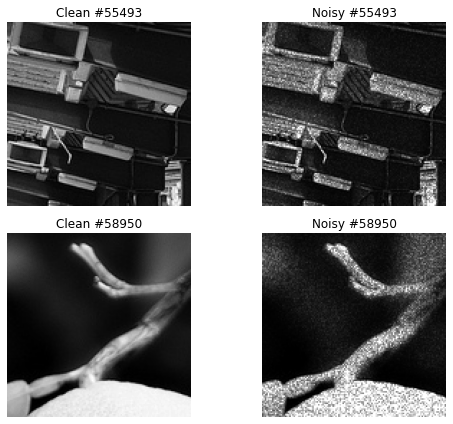

In [4]:
def visualize_n_pairs(dataset, n=5, randomize=True):
    """
    Visualize n (clean, noisy) image pairs from the dataset.

    Parameters:
    - dataset: instance of ImagePatchDataset
    - n (int): number of samples to show
    - randomize (bool): whether to randomly sample or take first n
    """
    indices = random.sample(range(len(dataset)), n) if randomize else list(range(n))

    plt.figure(figsize=(8, 3 * n))

    for idx, sample_idx in enumerate(indices):
        noisy, clean = dataset[sample_idx]
        noisy_img = noisy.squeeze().numpy()
        clean_img = clean.squeeze().numpy()

        # Clean image
        plt.subplot(n, 2, 2 * idx + 1)
        plt.imshow(clean_img, cmap='gray')
        plt.title(f"Clean #{sample_idx}")
        plt.axis("off")

        # Noisy image
        plt.subplot(n, 2, 2 * idx + 2)
        plt.imshow(noisy_img, cmap='gray')
        plt.title(f"Noisy #{sample_idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_n_pairs(train_dataset, n=2, randomize=True)

### Model

In [5]:
class WMSA(nn.Module):
    """ Self-attention module in Swin Transformer
    """

    def __init__(self, input_dim, output_dim, head_dim, window_size, type):
        super(WMSA, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.head_dim = head_dim
        self.scale = self.head_dim ** -0.5
        self.n_heads = input_dim//head_dim
        self.window_size = window_size
        self.type=type
        self.embedding_layer = nn.Linear(self.input_dim, 3*self.input_dim, bias=True)

        # TODO recover
        # self.relative_position_params = nn.Parameter(torch.zeros(self.n_heads, 2 * window_size - 1, 2 * window_size -1))
        self.relative_position_params = nn.Parameter(torch.zeros((2 * window_size - 1)*(2 * window_size -1), self.n_heads))

        self.linear = nn.Linear(self.input_dim, self.output_dim)

        trunc_normal_(self.relative_position_params, std=.02)
        self.relative_position_params = torch.nn.Parameter(self.relative_position_params.view(2*window_size-1, 2*window_size-1, self.n_heads).transpose(1,2).transpose(0,1))

    def generate_mask(self, h, w, p, shift):
        """ generating the mask of SW-MSA
        Args:
            shift: shift parameters in CyclicShift.
        Returns:
            attn_mask: should be (1 1 w p p),
        """
        # supporting sqaure.
        attn_mask = torch.zeros(h, w, p, p, p, p, dtype=torch.bool, device=self.relative_position_params.device)
        if self.type == 'W':
            return attn_mask

        s = p - shift
        attn_mask[-1, :, :s, :, s:, :] = True
        attn_mask[-1, :, s:, :, :s, :] = True
        attn_mask[:, -1, :, :s, :, s:] = True
        attn_mask[:, -1, :, s:, :, :s] = True
        attn_mask = rearrange(attn_mask, 'w1 w2 p1 p2 p3 p4 -> 1 1 (w1 w2) (p1 p2) (p3 p4)')
        return attn_mask

    def forward(self, x):
        """ Forward pass of Window Multi-head Self-attention module.
        Args:
            x: input tensor with shape of [b h w c];
            attn_mask: attention mask, fill -inf where the value is True;
        Returns:
            output: tensor shape [b h w c]
        """
        if self.type!='W': x = torch.roll(x, shifts=(-(self.window_size//2), -(self.window_size//2)), dims=(1,2))
        x = rearrange(x, 'b (w1 p1) (w2 p2) c -> b w1 w2 p1 p2 c', p1=self.window_size, p2=self.window_size)
        h_windows = x.size(1)
        w_windows = x.size(2)
        # sqaure validation
        # assert h_windows == w_windows

        x = rearrange(x, 'b w1 w2 p1 p2 c -> b (w1 w2) (p1 p2) c', p1=self.window_size, p2=self.window_size)
        qkv = self.embedding_layer(x)
        q, k, v = rearrange(qkv, 'b nw np (threeh c) -> threeh b nw np c', c=self.head_dim).chunk(3, dim=0)
        sim = torch.einsum('hbwpc,hbwqc->hbwpq', q, k) * self.scale
        # Adding learnable relative embedding
        sim = sim + rearrange(self.relative_embedding(), 'h p q -> h 1 1 p q')
        # Using Attn Mask to distinguish different subwindows.
        if self.type != 'W':
            attn_mask = self.generate_mask(h_windows, w_windows, self.window_size, shift=self.window_size//2)
            sim = sim.masked_fill_(attn_mask, float("-inf"))

        probs = nn.functional.softmax(sim, dim=-1)
        output = torch.einsum('hbwij,hbwjc->hbwic', probs, v)
        output = rearrange(output, 'h b w p c -> b w p (h c)')
        output = self.linear(output)
        output = rearrange(output, 'b (w1 w2) (p1 p2) c -> b (w1 p1) (w2 p2) c', w1=h_windows, p1=self.window_size)

        if self.type!='W': output = torch.roll(output, shifts=(self.window_size//2, self.window_size//2), dims=(1,2))
        return output

    def relative_embedding(self):
        cord = torch.tensor(np.array([[i, j] for i in range(self.window_size) for j in range(self.window_size)]))
        relation = cord[:, None, :] - cord[None, :, :] + self.window_size -1
        # negative is allowed
        return self.relative_position_params[:, relation[:,:,0].long(), relation[:,:,1].long()]


class Block(nn.Module):
    def __init__(self, input_dim, output_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer Block
        """
        super(Block, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        assert type in ['W', 'SW']
        self.type = type
        if input_resolution <= window_size:
            self.type = 'W'

        print("Block Initial Type: {}, drop_path_rate:{:.6f}".format(self.type, drop_path))
        self.ln1 = nn.LayerNorm(input_dim)
        self.msa = WMSA(input_dim, input_dim, head_dim, window_size, self.type)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.ln2 = nn.LayerNorm(input_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 4 * input_dim),
            nn.GELU(),
            nn.Linear(4 * input_dim, output_dim),
        )

    def forward(self, x):
        x = x + self.drop_path(self.msa(self.ln1(x)))
        x = x + self.drop_path(self.mlp(self.ln2(x)))
        return x


class ConvTransBlock(nn.Module):
    def __init__(self, conv_dim, trans_dim, head_dim, window_size, drop_path, type='W', input_resolution=None):
        """ SwinTransformer and Conv Block
        """
        super(ConvTransBlock, self).__init__()
        self.conv_dim = conv_dim
        self.trans_dim = trans_dim
        self.head_dim = head_dim
        self.window_size = window_size
        self.drop_path = drop_path
        self.type = type
        self.input_resolution = input_resolution

        assert self.type in ['W', 'SW']
        if self.input_resolution <= self.window_size:
            self.type = 'W'

        self.trans_block = Block(self.trans_dim, self.trans_dim, self.head_dim, self.window_size, self.drop_path, self.type, self.input_resolution)
        self.conv1_1 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)
        self.conv1_2 = nn.Conv2d(self.conv_dim+self.trans_dim, self.conv_dim+self.trans_dim, 1, 1, 0, bias=True)

        self.conv_block = nn.Sequential(
                nn.Conv2d(self.conv_dim, self.conv_dim, 3, 1, 1, bias=False),
                nn.ReLU(True),
                nn.Conv2d(self.conv_dim, self.conv_dim, 3, 1, 1, bias=False)
                )

    def forward(self, x):
        conv_x, trans_x = torch.split(self.conv1_1(x), (self.conv_dim, self.trans_dim), dim=1)
        conv_x = self.conv_block(conv_x) + conv_x
        trans_x = Rearrange('b c h w -> b h w c')(trans_x)
        trans_x = self.trans_block(trans_x)
        trans_x = Rearrange('b h w c -> b c h w')(trans_x)
        res = self.conv1_2(torch.cat((conv_x, trans_x), dim=1))
        x = x + res

        return x


# Squeeze-and-Excitation Block
class SqueezeExciteBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SqueezeExciteBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Squeeze operation
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)  # Bottleneck
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)  # Expand
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.shape
        se = self.global_avg_pool(x).view(batch_size, channels)
        se = self.relu(self.fc1(se))
        se = self.sigmoid(self.fc2(se))
        se = se.view(batch_size, channels, 1, 1)  # Reshape for broadcasting
        return x * se  # Channel-wise scaling


# Modified SCUNet with SE Blocks
class SCUNet(nn.Module):
    def __init__(self, in_nc=1, config=[2,2,2,2,2,2,2], dim=64, drop_path_rate=0.0, input_resolution=256):
        super(SCUNet, self).__init__()
        self.config = config
        self.dim = dim
        self.head_dim = 32
        self.window_size = 8

        # Drop path rate for each layer
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(config))]

        # Change: Convert m_head to a Sequential
        self.m_head = nn.Sequential(nn.Conv2d(in_nc, dim, 3, 1, 1, bias=False))

        begin = 0
        self.m_down1 = nn.Sequential(
            *[ConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution)
              for i in range(config[0])],
            nn.Conv2d(dim, 2*dim, 2, 2, 0, bias=False),
        )

        begin += config[0]
        self.m_down2 = nn.Sequential(
            *[ConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
              for i in range(config[1])],
            nn.Conv2d(2*dim, 4*dim, 2, 2, 0, bias=False),
        )

        begin += config[1]
        self.m_down3 = nn.Sequential(
            *[ConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//4)
              for i in range(config[2])],
            nn.Conv2d(4*dim, 8*dim, 2, 2, 0, bias=False),
        )

        begin += config[2]
        self.m_body = nn.Sequential(
            *[ConvTransBlock(4*dim, 4*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//8)
              for i in range(config[3])]
        )

        begin += config[3]
        self.m_up3 = nn.Sequential(
            nn.ConvTranspose2d(8*dim, 4*dim, 2, 2, 0, bias=False),
            SqueezeExciteBlock(4*dim),  # SE block
            *[ConvTransBlock(2*dim, 2*dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//4)
              for i in range(config[4])]
        )

        begin += config[4]
        self.m_up2 = nn.Sequential(
            nn.ConvTranspose2d(4*dim, 2*dim, 2, 2, 0, bias=False),
            SqueezeExciteBlock(2*dim),  # SE block
            *[ConvTransBlock(dim, dim, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution//2)
              for i in range(config[5])]
        )

        begin += config[5]
        self.m_up1 = nn.Sequential(
            nn.ConvTranspose2d(2*dim, dim, 2, 2, 0, bias=False),
            SqueezeExciteBlock(dim),  # SE block
            *[ConvTransBlock(dim//2, dim//2, self.head_dim, self.window_size, dpr[i+begin], 'W' if not i%2 else 'SW', input_resolution)
              for i in range(config[6])]
        )

        self.m_tail = nn.Sequential(nn.Conv2d(dim, in_nc, 3, 1, 1, bias=False))

    def forward(self, x0):
        h, w = x0.size()[-2:]
        paddingBottom = int(np.ceil(h/64)*64-h)
        paddingRight = int(np.ceil(w/64)*64-w)
        x0 = nn.ReplicationPad2d((0, paddingRight, 0, paddingBottom))(x0)

        x1 = self.m_head(x0)
        x2 = self.m_down1(x1)
        x3 = self.m_down2(x2)
        x4 = self.m_down3(x3)
        x = self.m_body(x4)
        x = self.m_up3(x + x4)
        x = self.m_up2(x + x3)
        x = self.m_up1(x + x2)
        x = self.m_tail(x + x1)

        x = x[..., :h, :w]
        return x

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

### Create Model Instance

In [6]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SCUNet().to(device)

Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000
Block Initial Type: W, drop_path_rate:0.000000
Block Initial Type: SW, drop_path_rate:0.000000


### Define the Loss Function

In [7]:
class CombinedMSESSIMLoss(nn.Module):
    def __init__(self, alpha=10):
        super(CombinedMSESSIMLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_true, y_pred):
        # Compute MSE
        mse = self.mse_loss(y_pred, y_true)

        # Compute SSIM per image in batch
        ssim_values = []
        for i in range(y_true.size(0)):
            y_true_np = y_true[i].squeeze().detach().cpu().numpy()
            y_pred_np = y_pred[i].squeeze().detach().cpu().numpy()
            ssim_val = structural_similarity(y_true_np, y_pred_np, data_range=1.0, win_size=7)
            ssim_values.append(ssim_val)

        # Average SSIM and compute combined loss
        ssim_loss = 1.0 - np.mean(ssim_values)
        combined = mse + (self.alpha * ssim_loss) ** 2
        return combined

loss_ = 'ps'
criterion = CombinedMSESSIMLoss(alpha=10)

# Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)


### Train the Model

In [ ]:
# Make sure checkpoints directory exists
os.makedirs("../checkpoints", exist_ok=True)

# Initialize model, optimizer, scheduler
model = SCUNet(in_nc=1).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# Training loop
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100):
    best_val_loss = float('inf')
    history = {"train_loss": [], "val_loss": []}  # Track history

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

        for noisy, clean in loop:
            noisy, clean = noisy.to(device), clean.to(device)

            optimizer.zero_grad()
            output = model(noisy)
            loss = criterion(clean, output)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * noisy.size(0)
            loop.set_postfix(loss=loss.item())

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for noisy, clean in val_loader:
                noisy, clean = noisy.to(device), clean.to(device)
                output = model(noisy)
                loss = criterion(clean, output)
                val_loss += loss.item() * noisy.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step()

        # Save loss to history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"\nEpoch {epoch+1} Summary: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

        #  Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_path = f"../checkpoints/scunet-{config_}-{loss_}.pth"
            torch.save(model.state_dict(), best_path)
            print(" Saved Best Model!")

    return history  # Return loss history

# Train the model
history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100
)
